# **Classifying Document**

Estimated time needed: **60** minutes

Imagine working at a prestigious newspaper or magazine company that boasts an extensive archive of documents dating back through the annals of time. Amid this treasure trove of information, a monumental task lies ahead: organizing these historical documents into their relevant topic sections. This strategic curation not only promises to enhance the user experience by delivering more streamlined content but also presents an opportunity to breathe new life into invaluable insights from the past through a modern lens. However, the sheer volume and scope of this undertaking call for a sophisticated solution.

![Documents Overload](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/docs.png)

The implementation of an automated machine learning system makes it very efficient. Such a system, equipped with advanced natural language processing and machine learning capabilities, could sift through the vast archives, categorizing articles into their respective topics with remarkable precision. As a result, readers would seamlessly access a wealth of knowledge tailored to their interests, while the editorial team gains newfound agility in content management.

In this project, you will embark on the exciting task of classifying news articles for a content search engine. The goal is to build a model that can automatically categorize news articles into different topics or classes, enabling the search engine to deliver relevant content to users efficiently. To achieve this, you will leverage the powerful torchtext library, which simplifies the process of creating a dataset for text classification analysis.

With torchtext, you'll have the flexibility to access and preprocess raw news data effortlessly. The library enables you to convert text strings into torch.Tensors, which are essential for training machine learning models. By using torchtext's convenient functionalities, you can set up an efficient data processing pipeline that prepares your text data for classification.

Throughout this tutorial, you'll demonstrate how to effectively shuffle and iterate through the processed data using torch.utils.data.DataLoader. This DataLoader simplifies the data handling process, allowing you to focus on building and training your text classification model effectively.


In [4]:
%%time
%pip install pandas numpy==1.26.4 seaborn==0.9.0 matplotlib scikit-learn pmdarima portalocker>=2.0.0 plotly dash
%pip install torch==2.3.0+cpu torchdata==0.9.0+cpu torchtext==0.18.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
splot 1.1.7 requires seaborn>=0.11.0, but yo

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

In [2]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

## Text classification
Let's build a text classification model using PyTorch and torchtext to classify news articles into one of the four categories: World, Sports, Business, and Sci/Tech.


In [3]:
train_iter = iter(AG_NEWS(split='train'))

In [4]:
y, text = next((train_iter))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [5]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tech"}
ag_news_label[y]

'Business'

In [6]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

In [7]:
train_iter = AG_NEWS(split="train")

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter),specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")

Vocabulary size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']


In [8]:
vocab(["age","hello"])

[2120, 12544]

### Dataset

You can convert the dataset into map-style datasets and then perform a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the AG_NEWS dataset.


In [9]:
train_iter , test_iter = AG_NEWS()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset)*0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader
Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.

The function **```text_pipeline```** will tokenize the input text, and **```vocab```** will then be applied to get the token indices.
The **```label_pipeline```** will ensure that the labels start at zero.


In [11]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
  return int(x) - 1

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `label_pipeline` and `text_pipeline` functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.


In [12]:
def collate_batch(batch):
  label_list, text_list, offsets = [],[],[0]
  for _label, _text in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text),dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list,dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list.to(device), text_list.to(device), offsets.to(device)

In [13]:
BATCH_SIZE = 64
train_dataloader = DataLoader(split_train_,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)

In [14]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([3, 1, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 2, 3, 3, 1, 3, 2, 2, 0, 0,
         3, 1, 2, 1, 0, 2, 3, 1, 1, 0, 1, 0, 3, 0, 1, 3, 3, 3, 0, 3, 2, 3, 0, 3,
         3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 0, 0, 2, 3]),
 tensor([   11,  2342,     3,  ..., 36224,  5130,     1]),
 tensor([   0,   55,  103,  142,  168,  197,  241,  272,  323,  367,  406,  438,
          478,  517,  556,  616,  647,  705,  729,  771,  818,  852,  886,  920,
          989, 1025, 1071, 1116, 1154, 1208, 1248, 1286, 1327, 1375, 1422, 1449,
         1481, 1530, 1581, 1625, 1658, 1694, 1738, 1777, 1810, 1849, 1881, 1962,
         2006, 2056, 2094, 2174, 2195, 2230, 2269, 2297, 2342, 2380, 2434, 2481,
         2505, 2570, 2618, 2654]))

### Neural network


In [15]:
from torch import nn

class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel,self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim,sparse=False)
    self.fc = nn.Linear(embed_dim,num_class)
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange,initrange)
    self.fc.weight.data.uniform_(-initrange,initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text,offsets)
    return self.fc(embedded)

In [16]:
emsize = 64


In [17]:
vocab_size = len(vocab)
vocab_size

95811

In [18]:
num_class


4

In [19]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model


TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [20]:
predicted_label = model(text, offsets)

In [21]:
predicted_label.shape

torch.Size([64, 4])

In [22]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [23]:
predict("I like sports",text_pipeline )

'World'

In [24]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [25]:
evaluate(test_dataloader)

0.23842105263157895

In [26]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [27]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 10/10 [00:59<00:00,  5.90s/it]


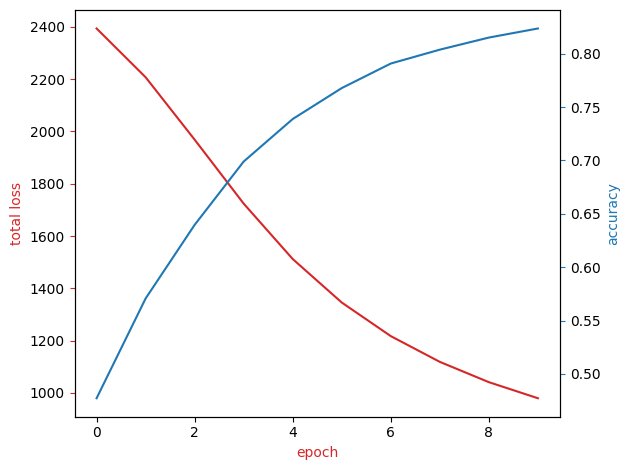

In [28]:
plot(cum_loss_list,acc_epoch)

In [29]:
evaluate(test_dataloader)

0.8177631578947369

In [30]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [31]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [38]:
result = predict(article, text_pipeline)
print(result)

Sports


In [34]:
model.load_state_dict(torch.load("my_model.pth"))
model.eval()

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [35]:
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

In [39]:
for i, article in enumerate(new_articles, start=1):
    prediction = predict(article, text_pipeline)
    print(f"Article {i} is classified as: {prediction}\n")

Article 1 is classified as: World

Article 2 is classified as: Sports

Article 3 is classified as: Business

Article 4 is classified as: World

Article 5 is classified as: World

Article 6 is classified as: Business

Article 7 is classified as: Sci/Tech

Article 8 is classified as: Sports

Article 9 is classified as: Sci/Tech

Article 10 is classified as: Sci/Tech

